In [107]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": "white"})
from datetime import date

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
# Filter FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, 
                        module="sklearn")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Exploratory Data Analysis

In [108]:
# Get the historical data for Microsoft as an example

msft = yf.Ticker("MSFT") 
stock_data_msft_example = msft.history(period="1mo")

# show meta information about the history (requires history() to be called first)
msft.history_metadata
# get all stock info : msft.info

{'currency': 'USD',
 'symbol': 'MSFT',
 'exchangeName': 'NMS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 511108200,
 'regularMarketTime': 1689096985,
 'gmtoffset': -14400,
 'timezone': 'EDT',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 331.43,
 'chartPreviousClose': 326.79,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EDT',
   'start': 1689062400,
   'end': 1689082200,
   'gmtoffset': -14400},
  'regular': {'timezone': 'EDT',
   'start': 1689082200,
   'end': 1689105600,
   'gmtoffset': -14400},
  'post': {'timezone': 'EDT',
   'start': 1689105600,
   'end': 1689120000,
   'gmtoffset': -14400}},
 'dataGranularity': '1d',
 'range': '1mo',
 'validRanges': ['1d',
  '5d',
  '1mo',
  '3mo',
  '6mo',
  '1y',
  '2y',
  '5y',
  '10y',
  'ytd',
  'max']}

In [109]:
stocks = ["AAPL", "MSFT", "AEE", "AIG", "ADBE", "NVDA", "META",
          "ROST", "JD", "PDD", "DDOG", "GOOGL", "AMZN", "SPY", "NDAQ"]

# Get the data for the stocks
today = date.today()
stock_data = yf.download(stocks, start="2022-07-10", end=today)

[*********************100%***********************]  15 of 15 completed


In [110]:
stock_data.columns

MultiIndex([('Adj Close',  'AAPL'),
            ('Adj Close',  'ADBE'),
            ('Adj Close',   'AEE'),
            ('Adj Close',   'AIG'),
            ('Adj Close',  'AMZN'),
            ('Adj Close',  'DDOG'),
            ('Adj Close', 'GOOGL'),
            ('Adj Close',    'JD'),
            ('Adj Close',  'META'),
            ('Adj Close',  'MSFT'),
            ('Adj Close',  'NDAQ'),
            ('Adj Close',  'NVDA'),
            ('Adj Close',   'PDD'),
            ('Adj Close',  'ROST'),
            ('Adj Close',   'SPY'),
            (    'Close',  'AAPL'),
            (    'Close',  'ADBE'),
            (    'Close',   'AEE'),
            (    'Close',   'AIG'),
            (    'Close',  'AMZN'),
            (    'Close',  'DDOG'),
            (    'Close', 'GOOGL'),
            (    'Close',    'JD'),
            (    'Close',  'META'),
            (    'Close',  'MSFT'),
            (    'Close',  'NDAQ'),
            (    'Close',  'NVDA'),
            (    'Close',   

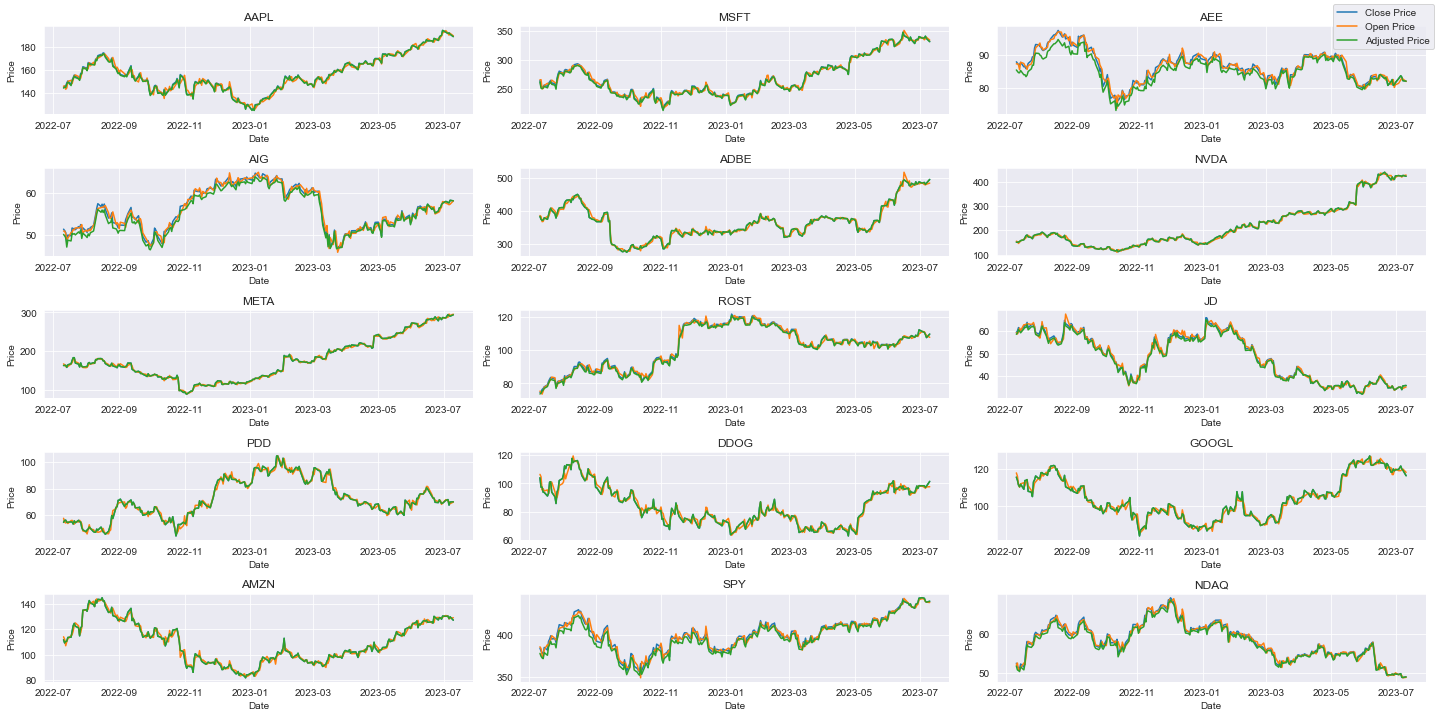

In [111]:
f = plt.figure(figsize=(20, 10))
for i, stock in enumerate(stocks) :
    plt.subplot(5, 3, i + 1)
    plt.plot(stock_data["Close"][stock], label='Close Price')
    plt.plot(stock_data["Open"][stock], label='Open Price')
    plt.plot(stock_data["Adj Close"][stock], label = "Adjusted Price")
    plt.title(stock)
    plt.xlabel('Date')
    plt.ylabel('Price')
    if i==0 : f.legend()

plt.tight_layout()
plt.show()

We can see that almost all stocks have the same upwards tendency in all of 3 the prices. The only exception is the NASDAQ index. However, the variations are heavy and abrupt.

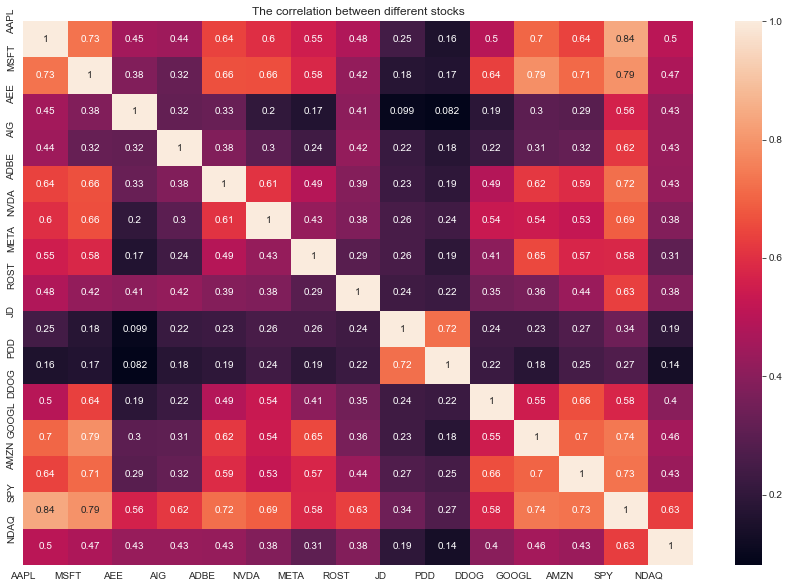

In [112]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.concat([stock_data['Adj Close'][stock].pct_change() for stock in stocks], axis=1).corr(), annot=True)
plt.yticks(range(len(stocks)), stocks)
plt.xticks(range(len(stocks)), stocks)
plt.title("The correlation between different stocks")
plt.show()

The observed results and correlations between stocks seem coherent, and we can assume that there are no anomalies in the data we have.

### Clustering to construct a diversified Portfolio

In [113]:
all_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'INTC', 'NVDA', 'ADBE',
               'PYPL', 'CSCO', 'NFLX', 'PEP', 'TSLA', 'CMCSA', 'AMGN', 'COST', 'TMUS', 'AVGO',
               'TXN', 'CHTR', 'QCOM', 'GILD', 'SBUX', 'INTU', 'VRTX', 'MDLZ', 'ISRG',
               'BKNG', 'ADP', 'REGN', 'ATVI', 'AMD', 'JD', 'MU', 'AMAT', 'ILMN', 'ADSK',
               'CSX', 'MELI', 'LRCX', 'ADI', 'ZM', 'BIIB', 'EA', 'KHC', 'WBA', 'LULU',
               'EBAY', 'MNST', 'DXCM', 'EXC', 'BIDU', 'XEL', 'WDAY', 'DOCU', 'SPLK', 'ORLY',
               'NXPI', 'CTSH', 'KLAC', 'SNPS', 'SGEN', 'ASML', 'IDXX', 'CSGP', 'CTAS', 'VRSK',
               'MAR', 'CDNS', 'PAYX', 'MCHP', 'SIRI', 'ANSS', 'VRSN', 'FAST', 'BMRN',
               'INCY','DLTR', 'SWKS', 'ALGN', 'CPRT', 'TTWO', 'CDW',
               'CHKP', 'WDC', 'ULTA', 'NTAP', 'FOXA', 'LBTYK']

all_stock_data = yf.download(all_stocks, start="2013-07-10", end=today)

[*********************100%***********************]  89 of 89 completed


In [114]:
start_date = "2015-01-01"
end_date = "2020-12-31"

index_ticker = "SPY"
index = yf.Ticker(index_ticker)
index_history = index.history(start=start_date, end=end_date)
index_adj_close = index_history["Close"]

#Create a dataset to fill 
data = pd.DataFrame(columns=["Stock", "Annualized Return on Equity",
                                "Annualized Volatility on Equity", 
                                "Daily Change in price",
                                "Daily Variation in price",
                                "Sharpe Ratio", "Correlation"])

for stock_ticker in all_stocks :
    
    # Extract the adjusted close prices for both
    stock = yf.Ticker(stock_ticker)
    history = stock.history(start=start_date, end=end_date)

    stock_adj_close = history["Close"]
    daily_returns = history["Close"].pct_change()
    
    # Calculate annualized return on equity (daily returns)
    annualized_return_on_equity = daily_returns.mean() * 252
    
    # Calculate annualized volatility on equity (daily returns)
    annualized_volatility_on_equity = daily_returns.std() * np.sqrt(252)
    
    # Calculate Sharpe Ratio
    risk_free_rate = 0.02  # Assuming a risk-free rate of 2%
    sharpe_ratio = (annualized_return_on_equity - risk_free_rate) / annualized_volatility_on_equity
    
    # Calculate the Daily Change in price
    daily_change = stock_adj_close.diff()
    
    # Calculate the Daily Variation in price
    daily_variation = daily_change.std()
    
    # Calculate daily change in price
    daily_change = stock_adj_close.diff()
    
    # Calculate the correlation with the S&P 500 index
    correlation = stock_adj_close.corr(index_adj_close)
    
    # create a line in a dataset with the computed variables
    data.loc[len(data)] = [stock_ticker, annualized_return_on_equity, 
                           annualized_volatility_on_equity,
                           daily_change, daily_variation,
                           sharpe_ratio, correlation]
    

In [115]:
data.head()

,Stock,Annualized Return on Equity,Annualized Volatility on Equity,Daily Change in price,Daily Variation in price,Sharpe Ratio,Correlation
0,AAPL,0.324825,0.296397,Date 2015-01-02 00:00:00-05:00 NaN 201...,1.176563,1.028434,0.906403
1,MSFT,0.318491,0.278321,Date 2015-01-02 00:00:00-05:00 NaN 201...,2.167365,1.072473,0.953143
2,AMZN,0.442884,0.309935,Date 2015-01-02 00:00:00-05:00 NaN 201...,1.634810,1.364431,0.951652
3,GOOGL,0.234109,0.267956,Date 2015-01-02 00:00:00-05:00 NaN 201...,0.924537,0.799046,0.974275
4,GOOG,0.236719,0.269325,Date 2015-01-02 00:00:00-05:00 NaN 201...,0.923278,0.804673,0.976841


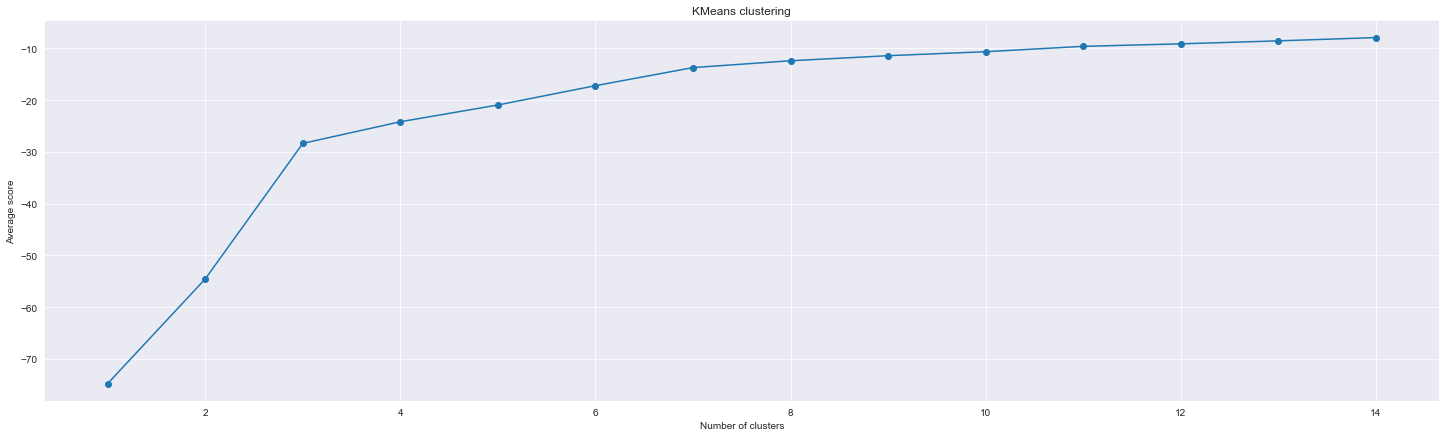

In [116]:
# Create a dataset with the features we want to cluster
X = data[["Annualized Return on Equity", "Annualized Volatility on Equity",
            "Sharpe Ratio", "Correlation"]]
X = StandardScaler().fit_transform(X)

K = np.arange(1, 15)
# do a grid search with kmeans
grid = GridSearchCV(KMeans(), param_grid={'n_clusters': K}, cv=5)
grid.fit(X)

# plot
plt.figure(figsize=(25, 7))
plt.plot(K, grid.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average score')
plt.title('KMeans clustering')
plt.show()

Text(0.5, 1.0, 'Clusters of stocks')

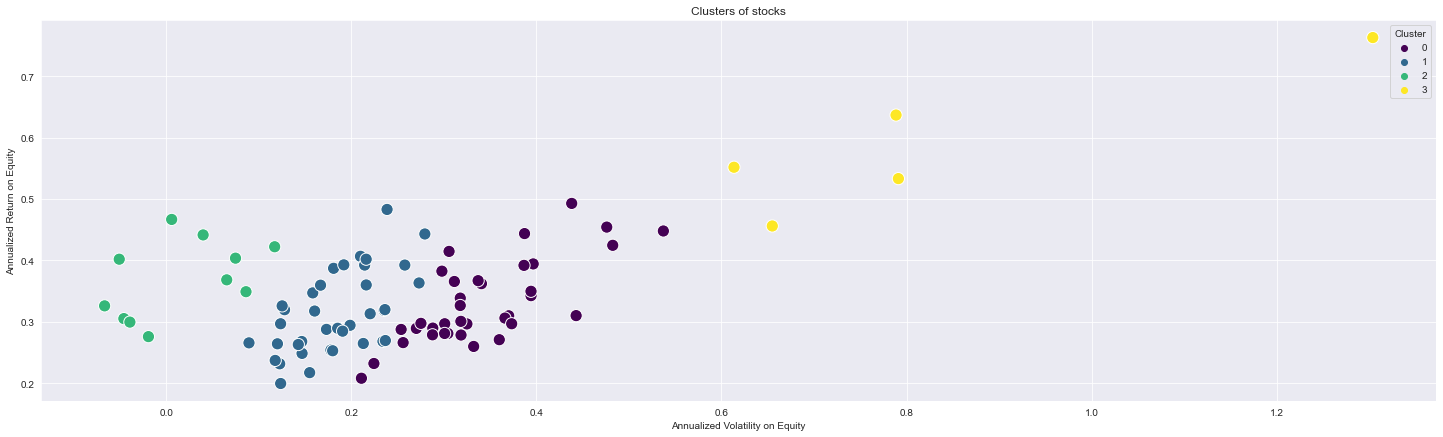

In [124]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X)

# Add the clusters to our dataset
data["Cluster"] = clusters

# Plot the clusters   
plt.figure(figsize=(25, 7))
sns.scatterplot(data=data, x="Annualized Return on Equity", y="Annualized Volatility on Equity", 
                hue="Cluster", s=150, palette="viridis")
plt.xlabel("Annualized Volatility on Equity")
plt.ylabel("Annualized Return on Equity")
plt.title("Clusters of stocks")

In [118]:
data.head()

,Stock,Annualized Return on Equity,Annualized Volatility on Equity,Daily Change in price,Daily Variation in price,Sharpe Ratio,Correlation,Cluster
0,AAPL,0.324825,0.296397,Date 2015-01-02 00:00:00-05:00 NaN 201...,1.176563,1.028434,0.906403,0
1,MSFT,0.318491,0.278321,Date 2015-01-02 00:00:00-05:00 NaN 201...,2.167365,1.072473,0.953143,0
2,AMZN,0.442884,0.309935,Date 2015-01-02 00:00:00-05:00 NaN 201...,1.634810,1.364431,0.951652,0
3,GOOGL,0.234109,0.267956,Date 2015-01-02 00:00:00-05:00 NaN 201...,0.924537,0.799046,0.974275,1
4,GOOG,0.236719,0.269325,Date 2015-01-02 00:00:00-05:00 NaN 201...,0.923278,0.804673,0.976841,1


In [119]:
# Group the clusters
cluster_0 = data[data["Cluster"]==0]
cluster_1 = data[data["Cluster"]==1]
cluster_2 = data[data["Cluster"]==2]
cluster_3 = data[data["Cluster"]==3]

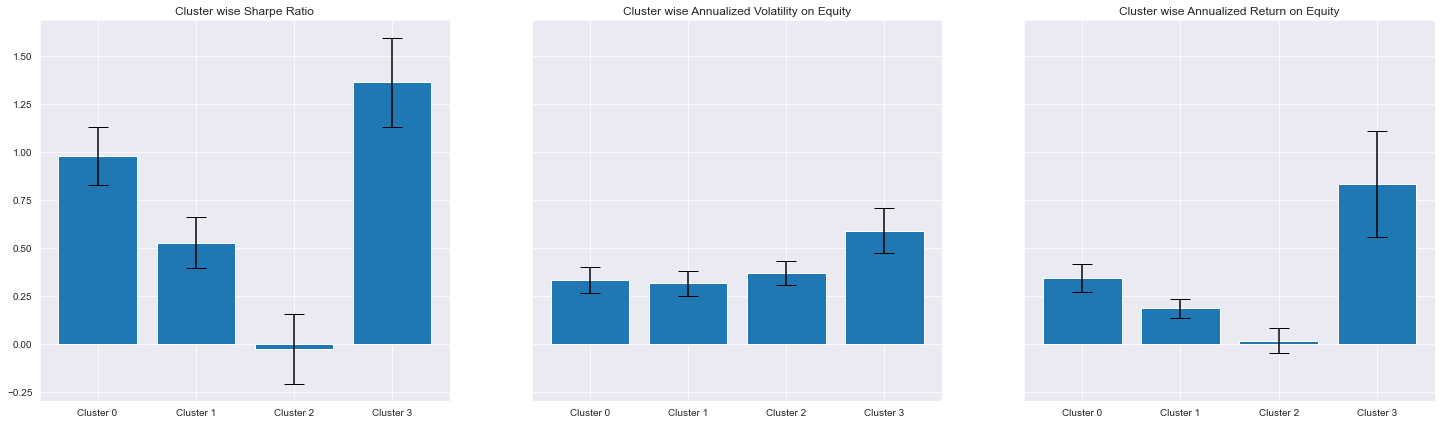

In [120]:
selected_features = ["Sharpe Ratio", "Annualized Volatility on Equity", "Annualized Return on Equity"]
f, axes = plt.subplots(1, 3, figsize=(25, 7), sharey=True)
for ax, feature in zip(axes, selected_features) :
        mean_feature_0 = cluster_0[feature].mean()
        mean_feature_1 = cluster_1[feature].mean()
        mean_feature_2 = cluster_2[feature].mean()
        mean_feature_3 = cluster_3[feature].mean()
        
        std_feature_0 = cluster_0[feature].std()
        std_feature_1 = cluster_1[feature].std()
        std_feature_2 = cluster_2[feature].std()
        std_feature_3 = cluster_3[feature].std()
        
        ax.bar(x=["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"],
                height=[mean_feature_0, mean_feature_1, mean_feature_2, mean_feature_3],
                yerr=[std_feature_0, std_feature_1, std_feature_2, std_feature_3],
                capsize=10)
        ax.set_title("Cluster wise " + feature)

In [121]:
portfolio = []
for cluster in [0, 1, 2, 3] :
    # select the top 3 stocks with sharp ratio and get their name
    top_3_sharp_ratio = data[data["Cluster"]==cluster].sort_values(by="Sharpe Ratio", ascending=False).head(3)["Stock"].values
    for ticker in top_3_sharp_ratio :
        portfolio.append(ticker)
print(f"The stocks selected in the portfolio : {portfolio}")

The stocks selected in the portfolio : ['AMZN', 'CPRT', 'SNPS', 'GOOG', 'GOOGL', 'SBUX', 'INCY', 'REGN', 'BMRN', 'ZM', 'DOCU', 'NVDA']


[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


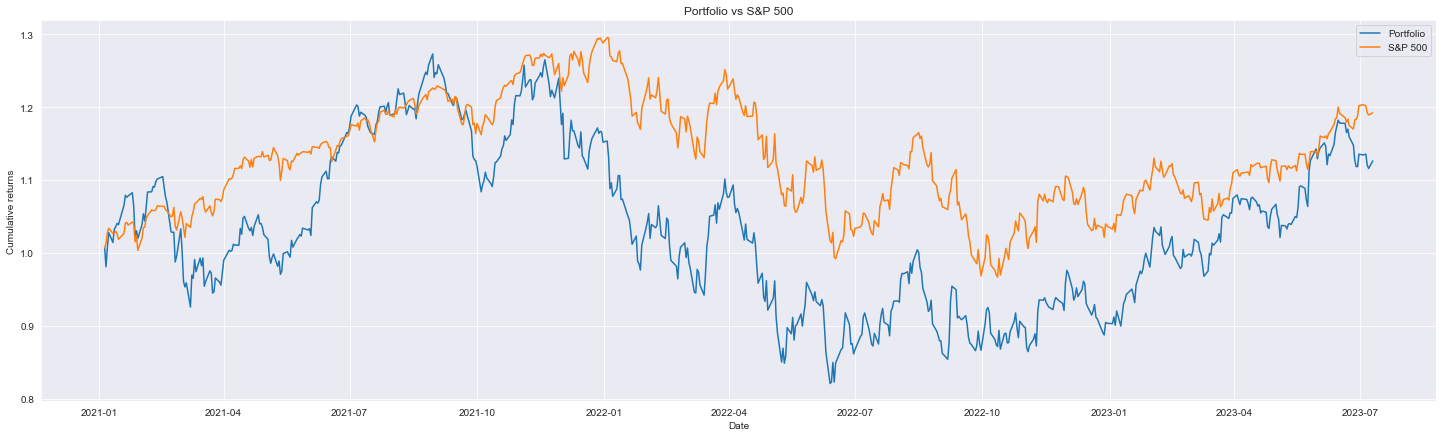

In [122]:
# Download recent data to validate the clustering method
portfolio_data = yf.download(portfolio, start="2021-01-01", end=today)
spy_index_data = yf.download("SPY", start="2021-01-01", end=today)

# Calculate the daily returns for both the stock and the index based on 
# their historical price data
portfolio_daily_returns = portfolio_data["Close"].sum(axis=1).pct_change()
spy_index_daily_returns = spy_index_data["Close"].pct_change()

# Calculate the cumulative returns for both the stock and the index by 
# summing up the daily returns.
portfolio_cumulative_returns = (portfolio_daily_returns + 1).cumprod()
spy_index_cumulative_returns = (spy_index_daily_returns + 1).cumprod()

# plot a comparison
plt.figure(figsize=(25, 7))
plt.plot(portfolio_cumulative_returns, label="Portfolio")
plt.plot(spy_index_cumulative_returns, label="S&P 500")
plt.title("Portfolio vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative returns")
plt.legend()
plt.show()